In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from diproperm.DiProPerm import DiProPerm

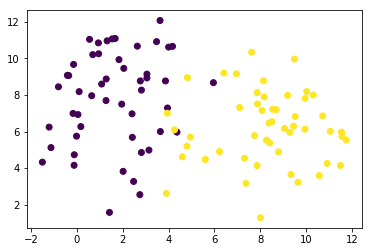

In [2]:
X, y = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=2, random_state=20)
plt.scatter(X[:, 0], X[:, 1], c=y)

In [3]:
# fit DiProPerm using mean difference classifier
# compute md, t and auc summary statistics
# sample 1000 permutations
dpp = DiProPerm(B=1000, stat=['md', 't', 'auc'], clf='md')
dpp.fit(X, y)

Two class DiProPerm

In [4]:
# the results are stored in dpp.test_stats_[STAT] where STAT is the desired summary statistic
print('DiProPerm using md statistic')
print(dpp.test_stats_['md'])

print('\nDiProPerm using t statistic')
print(dpp.test_stats_['t'])

print('\nDiProPerm using auc statistic')
print(dpp.test_stats_['auc'])

DiProPerm using md statistic
{'obs': 6.811364163879696, 'pval': 0.0, 'rejected': True, 'cutoff_val': 1.576967672454153, 'Z': 13.542980565769774}

DiProPerm using t statistic
{'obs': 18.033513549658643, 'pval': 0.0, 'rejected': True, 'cutoff_val': 2.318726517768431, 'Z': 26.732643547490216}

DiProPerm using auc statistic
{'obs': 0.996, 'pval': 0.0, 'rejected': True, 'cutoff_val': 0.6304, 'Z': 11.955417155390029}


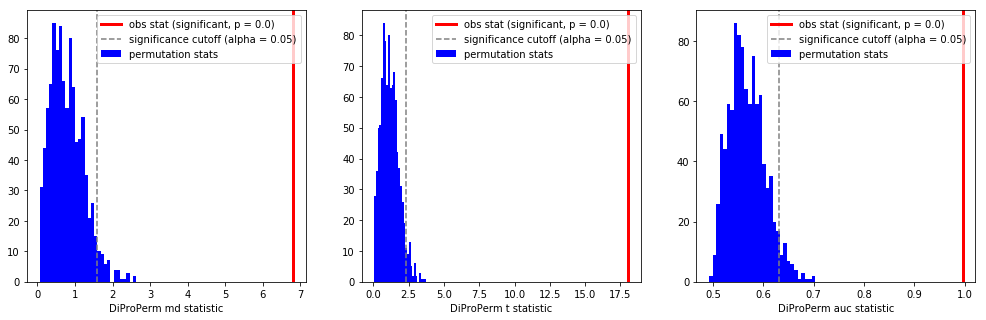

In [5]:
# show histogram of summary statistics
plt.figure(figsize=[17, 5])
plt.subplot(1, 3, 1)
dpp.hist('md')
plt.subplot(1, 3, 2)
dpp.hist('t')
plt.subplot(1, 3, 3)
dpp.hist('auc')

## custom linear classifiers
The `clf` argument can take a function which takes (X, y) data and returns scores (where scores = Xw, w = classification normal vector).

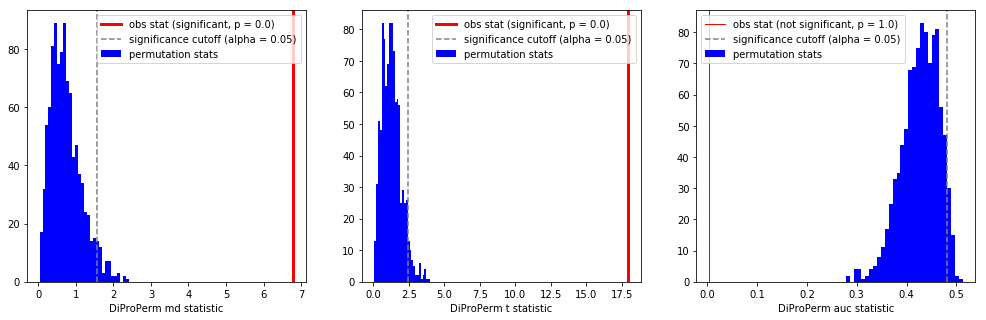

In [6]:
from diproperm.classifiers import get_training_fun
from sklearn.svm import LinearSVC

# clf fits an SVM, selecting C using 5 fold cross-validation, then returns the scores
# of the training data
clf = get_training_fun(clf=LinearSVC(max_iter=10000),  # max_iter set only to suppress annoying warning messages
                       param_grid={'C': [.0001, .001, .01, 1, 10, 100]},  # C grid to cross-validate over
                       metric='roc_auc', n_splits=5)

dpp = DiProPerm(B=1000, stat=['md', 't', 'auc'], clf=clf)
dpp.fit(X, y)

plt.figure(figsize=[17, 5])
plt.subplot(1, 3, 1)
dpp.hist('md')
plt.subplot(1, 3, 2)
dpp.hist('t')
plt.subplot(1, 3, 3)
dpp.hist('auc')

In [7]:
# the clf object above is a function which takes an X, y input,
# trains SVM using 5 fold cross-valdiation, then returns the
# sores of the training data
print(clf(X, y))

[ 0.69551688  3.88188321  9.02449958  4.85797332  4.39666355  1.30545436
  1.71637793 -2.38360513  0.55272888 -1.61496989 -1.24591925  5.87343774
  8.10420209  1.39025241  7.21454395  5.77956417  6.7686873   1.12125218
  7.68353512  2.89219437 -2.51119384  3.92239358 -1.43384118  8.86576492
  4.32695711 -1.84114932 -1.61041045  3.66840421 -3.13106115  1.53749825
  9.12499699 -3.22330864 -3.44970848  0.40492979 -3.28109879  7.175458
 -2.59463494  1.42153212  8.54778084  0.48240983 -2.16036875  9.56228061
  9.36195748 -2.56769804  1.79349699  5.50010422  2.88649731  5.21657247
  6.25456484 -1.92095514 -2.99512899  2.23399037 -2.0674346   5.47891412
  7.46099466  5.97694    -0.90393142 -2.69652337  5.94039516  5.06679936
  2.8689152   6.87881563  0.04655597  6.93503516 -0.18833013  6.61099394
 -0.53470743  8.97853518  0.06032314 -3.21593663 -1.83130861  5.37024011
 -1.42674797 -1.71409594  5.97809588  2.87328111  2.87683168  0.8482865
 -1.07426454  7.96632333  5.80683566 -1.9518715   6.94

In [8]:
# for details see diproperm.classifiers.py
print(clf.__doc__)


        Selects hyper-parameters using cross-validation. Then refits
        using the full data set and returns the classification scores.

        Parameters
        -----------
        X (ndarray): dataset with observations on rows

        y (list): class labels

        Output
        -----
        let w = normalized classification vector; returns the
        training data scores (i.e. projection onto normal vector)
        which are given by s = Xw
        


## parallel processing

The permutation statistics can be sampled in parallel using sklearn.externals.joblib.Parallel

In [9]:
# sample DiProPerm not in parallel 
%time dpp = DiProPerm(B=10000, stat=['md', 't', 'auc']).fit(X, y)

# sample permutation in parallel using all available cores
%time dpp = DiProPerm(B=10000, stat=['md', 't', 'auc'], n_jobs=-1).fit(X, y)

CPU times: user 12.2 s, sys: 31.9 ms, total: 12.2 s
Wall time: 12.2 s
CPU times: user 388 ms, sys: 74.9 ms, total: 463 ms
Wall time: 5.6 s


## custom test statistics

The user can provide custom test statistics which are functions of the observed statistic and the permutation statistics. For example, suppose we want the "robust" Z statistic (i.e. median/mad) instead of the standard Z statistic.

In [21]:
from statsmodels.robust.scale import mad

def robust_Z(obs_stat, perm_samples):
    return (obs_stat - np.median(perm_samples))/mad(perm_samples)

# should be an interable where each entry is a tuple containing
# a string (naming the statistic) and a function which computes
# the statistic.
custom_test_stats = [('robust_Z', robust_Z)]

dpp = DiProPerm(custom_test_stats=custom_test_stats).fit(X, y)

# notice robust_Z is one of the keys of test_stats_
print(dpp.test_stats_['md'].keys()) 
print()
print('standard Z statistic', dpp.test_stats_['md']['Z'])
print('robust Z statistic', dpp.test_stats_['md']['robust_Z'])

dict_keys(['obs', 'pval', 'rejected', 'cutoff_val', 'Z', 'robust_Z'])

standard Z statistic 14.563581147639274
robust Z statistic 14.41512244885523
